In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reading

First we load the dataset, and check for any nulls. 

In [2]:
df = pd.read_csv('data/olist_order_reviews_dataset.csv')

In [3]:
df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [4]:
df.dtypes

review_id                  object
order_id                   object
review_score                int64
review_comment_title       object
review_comment_message     object
review_creation_date       object
review_answer_timestamp    object
dtype: object

In [5]:
df.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [6]:
df.isnull().count()

review_id                  100000
order_id                   100000
review_score               100000
review_comment_title       100000
review_comment_message     100000
review_creation_date       100000
review_answer_timestamp    100000
dtype: int64

In [7]:
df.nunique()

review_id                  99173
order_id                   99441
review_score                   5
review_comment_title        4600
review_comment_message     36921
review_creation_date         637
review_answer_timestamp    99010
dtype: int64

# Using Reviews to Predict Score

Problem: Given the review text, try and predict what the user rated for the product. 

We will use the text from 
1. `review_comment_title`
2. `review_comment_message`

To predict `review_score`

We will not take into account any entry that does not have at least 1 of the columns mentioned above

Methods:
- Naive Bayes
- Logistic Regression
- LSTM

In [8]:
df = df[~df['review_comment_message'].isnull() | ~df['review_comment_title'].isnull()]

In [9]:
df = df[['review_comment_title', 'review_comment_message', 'review_score']].reset_index(drop=True)

In [10]:
df = df.fillna('')
df['review'] = df['review_comment_title'] + ' ' + df['review_comment_message']
df['review'] = df['review'].str.strip()
df['length'] = df['review'].str.len()

In [11]:
df.head()

,review_comment_title,review_comment_message,review_score,review,length
0,,Recebi bem antes do prazo estipulado.,5,Recebi bem antes do prazo estipulado.,37
1,,Parabéns lojas lannister adorei comprar pela I...,5,Parabéns lojas lannister adorei comprar pela I...,100
2,recomendo,aparelho eficiente. no site a marca do aparelh...,4,recomendo aparelho eficiente. no site a marca ...,184
3,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4,"Mas um pouco ,travando...pelo valor ta Boa.",43
4,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",5,"Super recomendo Vendedor confiável, produto ok...",72


# Analysis

count    43482.000000
mean         3.674417
std          1.614854
min          1.000000
25%          2.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_score, dtype: float64


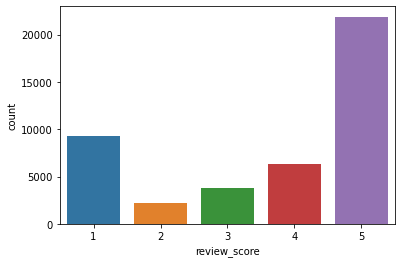

<AxesSubplot:xlabel='review_score'>

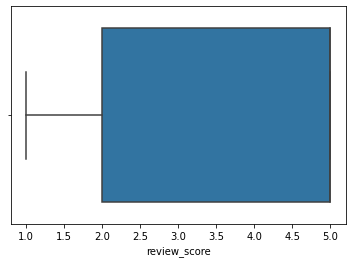

In [12]:
print(df['review_score'].describe())
sns.countplot(x="review_score", data=df)
plt.show()
sns.boxplot(x="review_score", data=df)

# Review Score
The review score ranged from 1-5, with a mean of 3.67, and most of the reviews being a 5

count    43482.000000
mean        70.435606
std         55.871351
min          0.000000
25%         28.000000
50%         55.000000
75%         98.000000
max        229.000000
Name: length, dtype: float64


<AxesSubplot:xlabel='length'>

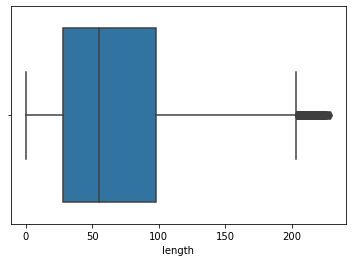

In [13]:
print(df['length'].describe())
sns.boxplot(x="length", data=df)

# Review
Each review is 0-229 characters long, with an average of roughly 70 characters. About a sentence

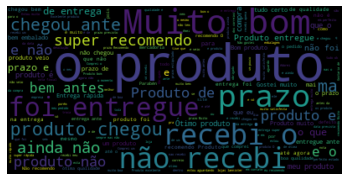

In [14]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Generate wordcloud
def generateWordCloud(text):
    wordcloud = WordCloud().generate(text)

    # Show wordcloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
generateWordCloud(" ".join(review for review in df['review']))


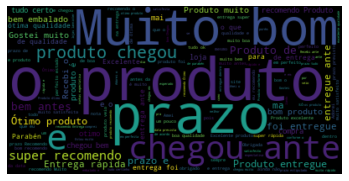

In [15]:
generateWordCloud(" ".join(review for review in df[df['review_score'] > 3]['review']))

- antes prazo: before deadline
- produto chegou: product arrived
- super recomendo: super recommended
- chegou ante: arrived before
- dentro prazo: within term
- muito bom: very good

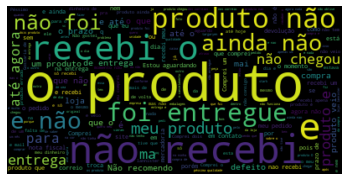

In [16]:
generateWordCloud(" ".join(review for review in df[df['review_score'] < 3]['review']))

- não recebi: not received
- produto não: no product
- não recomendo: not recommended
- ainda não: not yet
- foi entregue: was delivered
- não foi: it was not

# Pre-processing of Text

1. We combine the review title and review together
2. We remove any review less than 10 characters long. Single word reviews are not very helpful
2. We remove any punctuation, newlines, excess whitespace, stopwords, numbers
3. Stem the words

https://towardsdatascience.com/review-rating-prediction-a-combined-approach-538c617c495c

https://medium.com/@datamonsters/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908

https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk

https://towardsdatascience.com/a-beginners-guide-to-sentiment-analysis-in-python-95e354ea84f6

In [17]:
# Remove stopwords
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer # Portuguese stemmer

nltk.download('stopwords')
nltk.download('rslp')
portuguese_stopwords = stopwords.words('portuguese')
stemmer = nltk.stem.RSLPStemmer()

def process_text(text):
    text = ''.join([c for c in text if c not in string.punctuation]) # Remove punctuation
    text = ''.join([c for c in text if not c.isdigit()]) # Remove numbers
    text = text.lower().strip() # Lowercase and strip
    
    # remove stopwords and stem
    text = [stemmer.stem(word) for word in text.split() if word not in portuguese_stopwords] 
    return ' '.join(text)

df = df[df['length'] > 10]
df['review'] = df['review'].apply(lambda x: process_text(x))

[nltk_data] Downloading package stopwords to C:\Users\Toh Hong
[nltk_data]     Xiang\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package rslp to C:\Users\Toh Hong
[nltk_data]     Xiang\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping stemmers\rslp.zip.


       word   freq
36   produt  21244
38   entreg  12913
3      praz   8533
9     compr   7713
0     receb   7008
23     cheg   6646
16    recom   5886
2       ant   5728
72      bom   4853
144     vei   3418
45     ótim   3337
1       bem   3126
6       loj   2950
118    qual   2867
33      sup   2591
116   rápid   2570
39     gost   2514
71     aind   2453
108     tud   2334
254     dia   2312


<AxesSubplot:xlabel='freq', ylabel='word'>

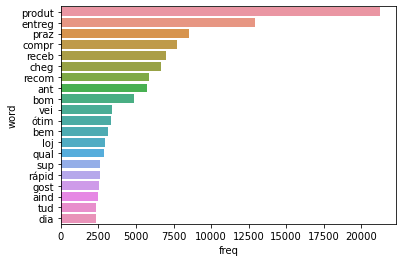

In [18]:
word_freqs = {}
for sentence in df['review']:
    for word in sentence.split():
        if word in word_freqs:
            word_freqs[word] += 1
        else:
            word_freqs[word] = 1
            
df_word_freqs = pd.DataFrame(word_freqs.items(), columns=['word', 'freq']).sort_values(by='freq', ascending=False)
print(df_word_freqs.head(20))
sns.barplot(y='word', x='freq', data=df_word_freqs.head(20))

# Preparing data for classifier

[TFIDF Information](https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/)

We will use TF-IDF (Term Frequency–Inverse Document Frequency) to encode the sentences
- Term Frequency: This summarizes how often a given word appears within a document.
- Inverse Document Frequency: This downscales words that appear a lot across documents.

In [19]:
X = df['review']
y = df['review_score']

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

def testClassifier(clf, X, y, X_transformer=None, y_transformer=None, plot_confusion_matrix=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    if X_transformer:
        X_train = X_transformer.fit_transform(X_train)
        X_test = X_transformer.transform(X_test)
    if y_transformer:
        y_train = y_transformer.fit_transform(y_train)
        y_test = y_transformer.fit_transform(y_test)
    
    print(clf.fit(X_train, y_train))
    cross_validation_scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(f"Average 5-fold cross validation score: {sum(cross_validation_scores)/len(cross_validation_scores)}")
    print(f"Score: {clf.score(X_test, y_test)}")
    print("\n")
    
    if plot_confusion_matrix:
        ax = plt.axes()
        sns.heatmap(confusion_matrix(y_test, clf.predict(X_test)), annot=True, fmt="d", ax=ax)
        ax.set_title(clf.__str__())
        plt.show()

In [21]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso

testClassifier(LinearRegression(), X, y, TfidfVectorizer(), None)
testClassifier(LogisticRegression(class_weight='balanced', max_iter=1000), X, y, TfidfVectorizer(), None)
testClassifier(Ridge(), X, y, TfidfVectorizer(), None)
testClassifier(Lasso(), X, y, TfidfVectorizer(), None)

LinearRegression()
Average 5-fold cross validation score: 0.4616688216815816
Score: 0.48936241267838165


LogisticRegression(class_weight='balanced', max_iter=1000)
Average 5-fold cross validation score: 0.5749117084474671
Score: 0.5652726041313918


Ridge()
Average 5-fold cross validation score: 0.6237558388104546
Score: 0.625402650914799


Lasso()
Average 5-fold cross validation score: -0.00042873033454835505
Score: -3.021717666795709e-05




MultinomialNB()
Average 5-fold cross validation score: 0.6693637925363153
Score: 0.6691500169319337




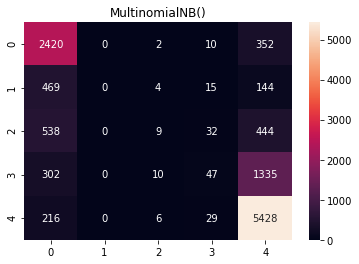

BernoulliNB()
Average 5-fold cross validation score: 0.6410972750369429
Score: 0.656874365052489




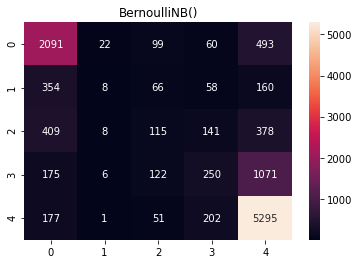

ComplementNB()
Average 5-fold cross validation score: 0.6596392121417542
Score: 0.6636471385032171




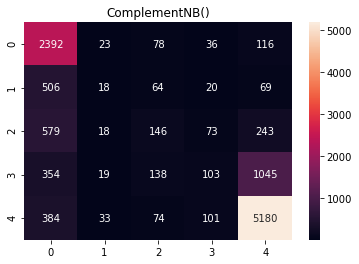

In [22]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB, GaussianNB
testClassifier(MultinomialNB(), X, y, TfidfVectorizer(), None, True)
testClassifier(BernoulliNB(), X, y, TfidfVectorizer(), None, True)
testClassifier(ComplementNB(), X, y, TfidfVectorizer(), None, True)
# testClassifier(GaussianNB(), X, y, TfidfVectorizer(), None, True)

KNeighborsRegressor()
Average 5-fold cross validation score: 0.371360857139987
Score: 0.3359570864390433


KNeighborsClassifier()
Average 5-fold cross validation score: 0.5588727348048328
Score: 0.5386894683372841




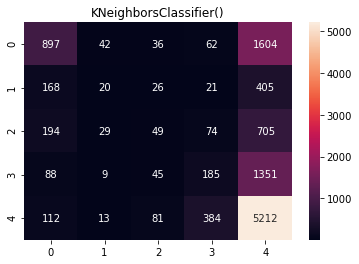

In [23]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
testClassifier(KNeighborsRegressor(), X, y, TfidfVectorizer(), None)
testClassifier(KNeighborsClassifier(), X, y, TfidfVectorizer(), None, True)

DecisionTreeClassifier(max_depth=10)
Average 5-fold cross validation score: 0.5635181872697407
Score: 0.572976633931595




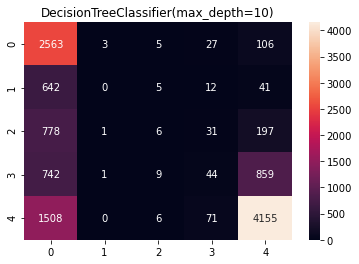

In [66]:
from sklearn.tree import DecisionTreeClassifier

testClassifier(DecisionTreeClassifier(max_depth=10), X, y, TfidfVectorizer(), None, True)

From the above, `MultinomialNB` performs the best. Let's also compare between 
- `TfidfVectorizer`
- `CountVectorizer`

MultinomialNB()
Average 5-fold cross validation score: 0.6671868033296121
Score: 0.6708432102946157




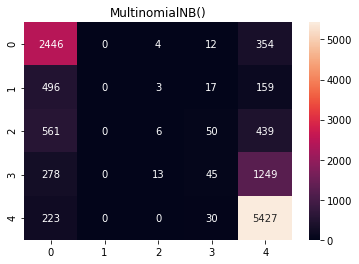

MultinomialNB()
Average 5-fold cross validation score: 0.672121761227512
Score: 0.6676261429055198




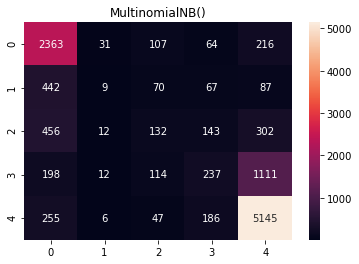

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

testClassifier(MultinomialNB(), X, y, TfidfVectorizer(), None, True)
testClassifier(MultinomialNB(), X, y, CountVectorizer(), None, True)

From the results above, there is not much difference between the 2 transformers

# Predicting sentiment based on review

Instead of predicting the score (1-5), lets predict whether we get a positive/negative review. We shall consider <= 3 as a negative review, and everything else as a positive review

In [25]:
df['is_positive'] = df['review_score'] > 3

In [26]:
df.head()

,review_comment_title,review_comment_message,review_score,review,length,is_positive
0,,Recebi bem antes do prazo estipulado.,5,receb bem ant praz estipul,37,True
1,,Parabéns lojas lannister adorei comprar pela I...,5,parabém loj lannist ador compr internet segur ...,100,True
2,recomendo,aparelho eficiente. no site a marca do aparelh...,4,recom aparelh efici sit marc aparelh impress d...,184,True
3,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4,pouc travandopel val ta boa,43,True
4,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",5,sup recom vend confi produt ok entreg ant praz,72,True


In [27]:
X = df['review']
y = df['is_positive']

testClassifier(LinearRegression(), X, y, TfidfVectorizer(), None)
testClassifier(LogisticRegression(class_weight='balanced', max_iter=1000), X, y, TfidfVectorizer(), None)
testClassifier(Ridge(), X, y, TfidfVectorizer(), None)
testClassifier(Lasso(), X, y, TfidfVectorizer(), None)

LinearRegression()
Average 5-fold cross validation score: 0.3892921177695785
Score: 0.4044222183831232


LogisticRegression(class_weight='balanced', max_iter=1000)
Average 5-fold cross validation score: 0.8812001541184685
Score: 0.8839315949881477


Ridge()
Average 5-fold cross validation score: 0.5651353389108618
Score: 0.5847596299999014


Lasso()
Average 5-fold cross validation score: -6.630647002348056e-05
Score: -6.318964554719031e-06




MultinomialNB()
Average 5-fold cross validation score: 0.8773904625107878
Score: 0.8769048425330173




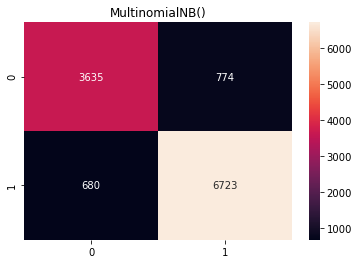

BernoulliNB()
Average 5-fold cross validation score: 0.8459306153493251
Score: 0.8484591940399594




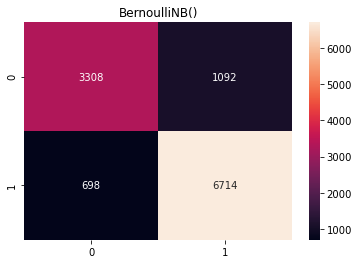

ComplementNB()
Average 5-fold cross validation score: 0.8750316229923054
Score: 0.8705553674229597




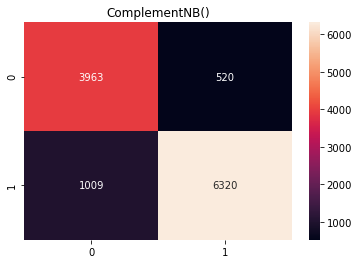

In [28]:
testClassifier(MultinomialNB(), X, y, TfidfVectorizer(), None, True)
testClassifier(BernoulliNB(), X, y, TfidfVectorizer(), None, True)
testClassifier(ComplementNB(), X, y, TfidfVectorizer(), None, True)
# testClassifier(GaussianNB(), X, y, TfidfVectorizer(), None, True)

KNeighborsRegressor()
Average 5-fold cross validation score: 0.2715055233382178
Score: 0.1931262913059768


KNeighborsClassifier()
Average 5-fold cross validation score: 0.7627619151458266
Score: 0.7308669150016932




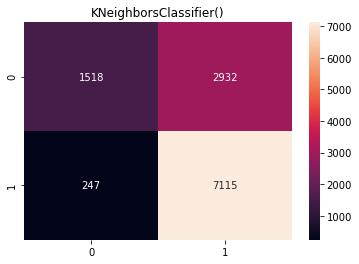

In [29]:
testClassifier(KNeighborsRegressor(), X, y, TfidfVectorizer(), None)
testClassifier(KNeighborsClassifier(), X, y, TfidfVectorizer(), None, True)

We can see that, we are able to classify with ~85% accuracy, the sentiment of the review based on the text of the review

We will now do some hyperparameter tuning to figure out the best set of parameters for `MultinomialNB`

In [60]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# params = dict(
#     alpha=[0.01, 0.05, 0.1, 0.5, 1.0],
#     fit_prior=[True, False]
# )

# Split to train/test sets
X = df['review']
y= df['review_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Transform with our vectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# skf = StratifiedKFold()
# mnb = MultinomialNB()
# clf = GridSearchCV(mnb, params, cv=skf)
clf = LogisticRegression()
clf.fit(X_train, y_train)
# print(f"Best score: {clf.best_score_}, Best parameters: {clf.best_params_}")

C:\Users\Toh Hong Xiang\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [61]:
def predict(text):
    transformed_text = process_text(text)
    transformed_text = vectorizer.transform([transformed_text])
    print(clf.predict(transformed_text))
#     print(clf.predict_proba(transformed_text))
    
predict('produto ruim')
predict('produto excelente')
predict('este foi um ótimo produto que chegou na hora')
predict('este foi um ótimo produto, mas chegou tarde')

[1]
[5]
[5]
[5]


In [68]:
predict(df[df['review_score'] == 2].iloc[1]['review_comment_message'])

[1]


In [67]:
import pickle
pickle.dump(clf, open('model.sav', 'wb'))